<a href="https://colab.research.google.com/github/SimeonHristov99/AI_Traffic_Sign_Classifier_Tensorflow/blob/main/traffic_sign_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description

## Traffic Sign Classifier

### The goal of this project is to build and train a traffic sign classifier. Results were generated in the context of the second  stage  of  the [GTSRB - German Traffic Sign Recognition Benchmark](https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign) dataset. The classifier is a convolutional neural network and is implemented using the deep learning framework [Keras](https://keras.io/) from the [TensorFlow](https://www.tensorflow.org/) library.

### Inspired by:
- [CNN Design for Real-Time Traffic Sign Recognition](https://www.sciencedirect.com/science/article/pii/S1877705817341231)
- [Man vs. computer: benchmarking machine learning algorithms for traffic sign recognition](https://christian-igel.github.io/paper/MvCBMLAfTSR.pdf)

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Loading data

In [5]:
# # # Run one time only. Requires Kaggle API access key to download the dataset.
# !pip install -q kaggle

# import os
# from google.colab import drive

# drive.mount('/gdrive')

# assert os.getcwd() == '/content'

# os.environ['KAGGLE_CONFIG_DIR'] = '../gdrive/MyDrive/kaggle'

# !kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign -p /content/data/ --unzip

Mounted at /gdrive
 97% 593M/612M [00:04<00:00, 168MB/s]
100% 612M/612M [00:04<00:00, 136MB/s]


In [6]:
traindf = pd.read_csv('/content/data/Train.csv',dtype=str)

In [7]:
BATCH_SIZE = 32
IM_SIZE = 32
CLASSES = 43
TRAIN_DATA_DIR = '/content/data'

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=0.2 # set validation split
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=traindf,
    directory=TRAIN_DATA_DIR,
    x_col='Path',
    y_col='ClassId',
    seed=42,
    batch_size=BATCH_SIZE,
    subset='training', # set as training data
    target_size=(IM_SIZE, IM_SIZE)
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=traindf,
    directory=TRAIN_DATA_DIR,
    x_col='Path',
    y_col='ClassId',
    seed=42,
    batch_size=BATCH_SIZE,
    subset='validation', # set as training data
    target_size=(IM_SIZE, IM_SIZE)
)

print(f'{len(train_generator)} training batches. Each with {train_generator[0][0].shape[0]} images.')
print(f'{len(val_generator)} validation batches. Each with {val_generator[0][0].shape[0]} images.')

Found 31368 validated image filenames belonging to 43 classes.
Found 7841 validated image filenames belonging to 43 classes.
981 training batches. Each with 32 images.
246 validation batches. Each with 32 images.


# Visualizing data

In [8]:
X_train_batch, y_train_batch = next(train_generator)
X_val_batch, y_val_batch = next(val_generator)

print(type(X_train_batch), X_train_batch.shape, type(y_train_batch), y_train_batch.shape)
print(type(X_val_batch), X_val_batch.shape, type(y_val_batch), y_val_batch.shape)

<class 'numpy.ndarray'> (32, 32, 32, 3) <class 'numpy.ndarray'> (32, 43)
<class 'numpy.ndarray'> (32, 32, 32, 3) <class 'numpy.ndarray'> (32, 43)


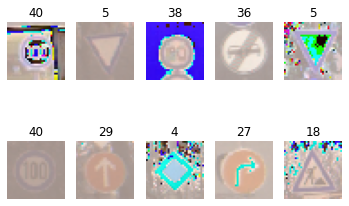

In [9]:
for i in range(10):
  plt.subplot(2, 5, i + 1)

  rand_idx = np.random.randint(X_train_batch.shape[0])
  image = X_train_batch[rand_idx]
  
  plt.imshow(image.astype('uint8'))
  plt.axis('off')
  plt.title(np.argmax(y_train_batch[rand_idx]))

plt.show()

# Choosing a model

In [23]:
input_shape = X_train_batch[0].shape

model = keras.Sequential([
 keras.layers.Conv2D(filters=32, kernel_size=5, activation='relu', padding='same', input_shape=input_shape),
 keras.layers.Conv2D(filters=32, kernel_size=5, activation='relu', padding='same'),
 keras.layers.Conv2D(filters=32, kernel_size=5, activation='relu', padding='same'),
 keras.layers.MaxPool2D(strides=2),
 keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
 keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
 keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
 keras.layers.MaxPool2D(strides=2),
 keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
 keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
 keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
 keras.layers.MaxPool2D(strides=2),
 keras.layers.Flatten(),
 keras.layers.Dropout(0.75),
 keras.layers.Dense(units=CLASSES, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training

In [24]:
model.fit(
    x=train_generator,
    validation_data=val_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_steps = val_generator.samples // BATCH_SIZE,
    epochs = 10
)

Epoch 1/10
980/980 [==============================] - 19s 19ms/step - loss: 1.6175 - accuracy: 0.5350 - val_loss: 15.8264 - val_accuracy: 0.0619
Epoch 2/10
980/980 [==============================] - 19s 19ms/step - loss: 0.3972 - accuracy: 0.8812 - val_loss: 20.9645 - val_accuracy: 0.1546
Epoch 3/10
980/980 [==============================] - 19s 19ms/step - loss: 0.2478 - accuracy: 0.9278 - val_loss: 28.0224 - val_accuracy: 0.1594
Epoch 4/10
980/980 [==============================] - 18s 19ms/step - loss: 0.2376 - accuracy: 0.9349 - val_loss: 28.0808 - val_accuracy: 0.1561
Epoch 5/10
980/980 [==============================] - 18s 19ms/step - loss: 0.2369 - accuracy: 0.9363 - val_loss: 32.5528 - val_accuracy: 0.1529
Epoch 6/10
980/980 [==============================] - 19s 19ms/step - loss: 0.2350 - accuracy: 0.9389 - val_loss: 31.2387 - val_accuracy: 0.1668
Epoch 7/10
980/980 [==============================] - 19s 19ms/step - loss: 0.2671 - accuracy: 0.9318 - val_loss: 30.5891 - val_ac

# Evaluation

In [12]:
# Coming soon ...